In [25]:
import numpy as np
import pandas as pd
import math
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def printVar (varname, var):

    print(varname)
    print(var)

def saveArray (name, array):

    pd.DataFrame(array).to_csv("savedVariables/" + name + ".csv", index=False, header=None)



In [26]:
# Set Boundary Conditions:
class BC_settings:

    left = "fixed_displacement"
    right = "traction"
    top = "traction"
    bottom = "traction"

    def __init__(self, edge):

        if edge == "l":
            if BC_settings.left == "traction":
                self.traction = True
                self.fixed_displacement = False
            elif BC_settings.left == "fixed_displacement":
                self.fixed_displacement = True
                self.traction = False

        if edge == "r":
            if BC_settings.right == "traction":
                self.traction = True
                self.fixed_displacement = False
            elif BC_settings.right == "fixed_displacement":
                self.fixed_displacement = True
                self.traction = False

        if edge == "t":
            if BC_settings.top == "traction":
                self.traction = True
                self.fixed_displacement = False
            elif BC_settings.top == "fixed_displacement":
                self.fixed_displacement = True
                self.traction = False

        if edge == "b":
            if BC_settings.bottom == "traction":
                self.traction = True
                self.fixed_displacement = False
            elif BC_settings.bottom == "fixed_displacement":
                self.fixed_displacement = True
                self.traction = False

BC_settings("b").fixed_displacement

False

In [27]:
# Solve the 2D Navier-Cauchy equation using a segregated finite volume method

# Define mesh geometry and boundary conditions

Lx = 0.02 #width of domain
Ly = 0.01 #height of domain

fac = 1

nx = 16       #number of control volumes in the x-direction
ny = 8    #number of control volumes in the y-direction


In [28]:
# Cantilever Setup 

tr_right_x = 0    #u boundary condition at the right boundary
tr_right_y = - 1e-6   #v boundary condition at the right boundary

tr_top_x = 0    #u boundary condition at the top boundary
tr_top_y = 0       #v boundary condition at the top boundary

tr_bottom_x = 0    #u boundary condition at the bottom boundary 
tr_bottom_y = 0  #v boundary condition at the bottom boundary

u_left = 0
v_left = 0


In [29]:
sys.path.append("/home/scottlevie/newPythonSolver/pythonsolver_new/tractionBCs/Classes/")

from index_and_direction import dim

print(dim().nx)

16


In [30]:
from index_and_direction import index
from index_and_direction import boundary_point_index
from index_and_direction import cell_index
from index_and_direction import displacement

In [31]:
# Define material properties

rho = 8050         #density of steel in kg/m^3
mu = 78*10e9       #shear modulus in Pa
K = 1.6*10e11      #bulk modulus in Pa

Lambda = K - (2/3)*mu

#print(Lambda)

E = mu*(2*(1+0.3))

In [32]:
## Define required variables

tf = 0.01           #total time in seconds
dx = Lx/nx          #length of each control volume in the x-direction
dy = Ly/ny          #length of each control volume in the y-direction
dt = tf/10          #size of time steps
Sfx = dy            #area vector x component (Area of East and West Faces)
Sfy = dx            #area vector y component (Area of North and South Faces)


In [33]:
## Define  position and time vectors

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
x = np.zeros((1,nx+2))   #position vector defining the center points of the control volumes in the x-direction.
x[0,nx+1] = Lx
x[0,1:nx+1] = np.arange(dx/2,Lx,dx)

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
y = np.zeros((1,ny+2))   #position vector defining the center points of the control volumes in the y-direction.
y[0,ny+1] = Ly
y[0,1:ny+1] = np.arange(dy/2,Ly,dy)

In [34]:
## Define required displacement matrices and b vector

u_new = np.zeros([(ny+2)*(nx+2),2])         #unknown displacements at t + 1    (Column 1 = x, Column2 = y)
u_old = np.zeros([(ny+2)*(nx+2),2])         #displacement at time t
u_old_old = np.zeros([(ny+2)*(nx+2),2])     #displacement at time t - 1

#rhs vector
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

## X equation:

In [35]:
class A(index, displacement):

    val = "value that stays in class without changning with instance"

    def __init__(self, xy):

        if xy == "x":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfx)/dx + ((2*mu)*Sfy)/dy
            self.a_N = + A.coef(xy, "N", "u")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "u")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "u")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "u")*(Sfx)/dx

        if xy == "y":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfy)/dy + ((2*mu)*Sfx)/dx 
            self.a_N = + A.coef(xy, "N", "v")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "v")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "v")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "v")*(Sfx)/dx

    def createMatrix(self):

        A_no_boundary = np.zeros([(ny+2)*(nx+2), (ny+2)*(nx+2)])
        # A_no_boundary = csr_matrix(A_no_boundary)  

        for j in np.arange(2, ny):     

            for k in np.arange((j*(nx+2)+2), (j*(nx+2)+nx)):  
                
                A_no_boundary[k,k] = self.a_P
                A_no_boundary[k,index(k).n] = -self.a_N
                A_no_boundary[k,index(k).s] = -self.a_S
                A_no_boundary[k, index(k).e] = -self.a_E
                A_no_boundary[k, index(k).w] = -self.a_W

        return A_no_boundary

    # b temporal term
    def b_temp(u_old, u_old_old, k, xy):

        if xy == "x":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy)
        if xy == "y":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy)
        
        return b_temporal_term
    
    def b_diff(k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"

        b_diffusion = (
                                Sfy*A.coef(xy, "N", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("NW", uv, u_previous, k))
                                    /dx)
                                + 
                                Sfy*A.coef(xy, "S", uv)*(
                                    (A.corner("SE", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dx)
                                +
                                Sfx*A.coef(xy, "E", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("SE", uv, u_previous, k))
                                    /dy)
                                +
                                Sfx*A.coef(xy, "W", uv)*(
                                    (A.corner("NW", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dy)
        )

        return b_diffusion
    
    def corner(corner_placement, uv, u_previous, k):
        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            return (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            return (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            return (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            return (1/4)*(disp.P + disp.NW + disp.N + disp.W)


    
    def coef(xy, face, uv):
        # could have and statements
        if xy == "x":
            if face == "N":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "S":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu
            if face == "E":
                if uv == "u":
                    return 2*mu + Lambda
                if uv == "v":
                    return Lambda
            if face == "W":
                if uv == "u":
                    return - (2*mu + Lambda)
                if uv == "v":
                    return - Lambda

        elif xy == "y":
            if face == "N":
                if uv == "u":
                    return Lambda
                if uv == "v":
                    return 2*mu + Lambda
            if face == "S":
                if uv == "u":
                    return - Lambda
                if uv == "v":
                    return - (2*mu + Lambda)
            if face == "E":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "W":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu

u_previous = u_new

# A.b_diff(25, "x", u_previous)

In [36]:
class boundaryCellTraction(A):

    def __init__(self, edges, xy):
        
        sw_S, sw_N, sw_W, sw_E = 1, 1, 1, 1

        for edge in edges:
            if edge == "b": sw_S = 0
            if edge == "t": sw_N = 0
            if edge == "l": sw_W = 0
            if edge == "r": sw_E = 0
        
        self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*sw_N + A(xy).a_S**sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W
        
        self.a_N = A(xy).a_N 
        self.a_S = A(xy).a_S 
        self.a_E = A(xy).a_E 
        self.a_W = A(xy).a_W 

        # self.a_faces = A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W 

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (boundaryCellTraction.corner(edges, "SE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (boundaryCellTraction.corner(edges, "NW", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dy)
                )

        for edge in edges:

            if (edge == "b") & (xy == "x") : S_term =  Sfy*tr_bottom_x  
            if (edge == "b") & (xy == "y") : S_term =  Sfy*tr_bottom_y  
            if (edge == "t") & (xy == "x") : N_term =  Sfy*tr_top_x  
            if (edge == "t") & (xy == "y") : N_term =  Sfy*tr_top_y  
            if (edge == "l") & (xy == "x") : W_term =  Sfx*tr_left_x  
            if (edge == "l") & (xy == "y") : W_term =  Sfx*tr_left_y  
            if (edge == "r") & (xy == "x") : E_term =  Sfx*tr_right_x  
            if (edge == "r") & (xy == "y") : E_term =  Sfx*tr_right_y        

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        for edge in edges:
            if (edge == "b") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.S)
            if (edge == "b") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.S)

            if (edge == "t") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.N)
            if (edge == "t") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.N)

            if (edge == "l") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.W)
            if (edge == "l") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.W)

            if (edge == "r") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.E)
            if (edge == "r") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.E)
        
        return corner

# boundaryCellTraction.b_diff(["b", "l"], 14, "x", u_previous)
   

In [37]:
class boundaryPointTraction(A):

    def __init__(self, edges, xy):    # The order matters for edges, bottom left corner on the bottom is : ["b", "l"]
        
        sw_S, sw_N, sw_W, sw_E = 0, 0, 0, 0

        if edges[0] == "b": sw_S = 1
        if edges[0] == "t": sw_N = 1
        if edges[0] == "l": sw_W = 1
        if edges[0] == "r": sw_E = 1
        
        a_P = (A(xy).a_N*sw_N + A(xy).a_S**sw_S )*2/(Sfy) + (A(xy).a_E*sw_E + A(xy).a_W*sw_W)*2/(Sfx)
        
        a_N = A(xy).a_N*2/(Sfy) # are terms cancel in derivation
        a_S = A(xy).a_S*2/(Sfy)
        a_E = A(xy).a_E*2/(Sfx)
        a_W = A(xy).a_W*2/(Sfx)

        if edges[0] == "b":
            self.a_N = a_P
            self.a_P = a_S
        if edges[0] == "t":
            self.a_S = a_P
            self.a_P = a_N
        if edges[0] == "l":
            self.a_E = a_P
            self.a_P = a_W
        if edges[0] == "r":
            self.a_W = a_P
            self.a_P = a_E
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        def N_term():
            
            N_term =( A.coef(xy, "N", uv)*(
                    (boundaryPointTraction.corner(edges, "E", uv, u_previous, k) - boundaryPointTraction.corner(edges, "W", uv, u_previous, k))
                    /dx)
            )

            return N_term

        def S_term():
            
            S_term =(
                    A.coef(xy, "S", uv)*(
                        (boundaryPointTraction.corner(edges, "E", uv, u_previous, k) - boundaryPointTraction.corner(edges, "W", uv, u_previous, k))
                        /dx)
                ) 
            return S_term
        def E_term():
            
            E_term =(
                    A.coef(xy, "E", uv)*(
                        (boundaryPointTraction.corner(edges, "N", uv, u_previous, k) - boundaryPointTraction.corner(edges, "S", uv, u_previous, k))
                        /dy)
                ) 
            return E_term
        def W_term():
            
            W_term =(
                        A.coef(xy, "W", uv)*(
                        (boundaryPointTraction.corner(edges, "N", uv, u_previous, k) - boundaryPointTraction.corner(edges, "S", uv, u_previous, k))
                        /dy)
                )
                
            return W_term

        # This can be tidied up/shortened

        if (edges[0] == "b") & (xy == "x") : b_diffusion =  tr_bottom_x  + N_term()
        if (edges[0] == "b") & (xy == "y") : b_diffusion =  tr_bottom_y  + N_term()
        if (edges[0] == "t") & (xy == "x") : b_diffusion =  tr_top_x + S_term()
        if (edges[0] == "t") & (xy == "y") : b_diffusion =  tr_top_y + S_term()
        if (edges[0] == "l") & (xy == "x") : b_diffusion =  tr_left_x + E_term()
        if (edges[0] == "l") & (xy == "y") : b_diffusion =  tr_left_y + E_term()
        if (edges[0] == "r") & (xy == "x") : b_diffusion =  tr_right_x + W_term()
        if (edges[0] == "r") & (xy == "y") : b_diffusion =  tr_right_y + W_term()  

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)


        if corner_placement == "E":
            corner =  (1/2)*(disp.E + disp.P)
        if corner_placement == "W":
            corner =  (1/2)*(disp.W + disp.P)
        if  corner_placement == "N":
            corner =  (1/2)*(disp.N + disp.P)
        if  corner_placement == "S":
            corner =  (1/2)*(disp.S + disp.P)

        if len(edges) > 1:

            if (edges[1] == "r") & (corner_placement == "E"):
                    corner =  disp.E
            if (edges[1] == "l") & (corner_placement == "W"):
                    corner =  disp.W
            if (edges[1] == "t") & (corner_placement == "N"):
                    corner =  disp.N
            if (edges[1] == "b") & (corner_placement == "S"):
                    corner =  disp.S
        
        return corner
# boundaryCellTraction.b_diff(["b", "l"], 14, "x", u_previous)
   

In [38]:
class boundaryCellDisplacement(A):

    def __init__(self, edges, xy):
        
        sw_S, sw_N, sw_W, sw_E = 1, 1, 1, 1

        for edge in edges:
            if edge == "b": sw_S = 2
            if edge == "t": sw_N = 2
            if edge == "l": sw_W = 2
            if edge == "r": sw_E = 2
        
        self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W
        
        self.a_N = A(xy).a_N*sw_N
        self.a_S = A(xy).a_S*sw_S
        self.a_E = A(xy).a_E*sw_E
        self.a_W = A(xy).a_W*sw_W

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (boundaryCellDisplacement.corner(edges, "NE", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (boundaryCellDisplacement.corner(edges, "SE", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (boundaryCellDisplacement.corner(edges, "NE", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (boundaryCellDisplacement.corner(edges, "NW", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "SW", uv, u_previous, k))
                        /dy)
                ) 

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        for edge in edges:
            if (edge == "b") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.S)
            if (edge == "b") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.S)

            if (edge == "t") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.N)
            if (edge == "t") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.N)

            if (edge == "l") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.W)
            if (edge == "l") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.W)

            if (edge == "r") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.E)
            if (edge == "r") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.E)

        if len(edges) > 1:

            if (edges[0] == "b") & (edges[1] == "l") & (corner_placement == "SW"):
                corner = disp.SW 
            if (edges[0] == "b") & (edges[1] == "r") & (corner_placement == "SE"):
                corner = disp.SE
            if (edges[0] == "t") & (edges[1] == "l") & (corner_placement == "NW"):
                corner = disp.NW
            if (edges[0] == "t") & (edges[1] == "r") & (corner_placement == "NE"):
                corner = disp.NE

        
        return corner

# boundaryCellDisplacement.b_diff(["b", "l"], 14, "x", u_previous)




In [39]:
def traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous):

    A_matrix[k,k] = boundaryCellTraction(edges, xy).a_P

    b_matrix[k] =(
                    boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                    +
                    boundaryCellTraction.b_diff(edges, k, xy, u_previous)  
                )
    for edge in edges:
        if edge == "b":
            #an
            A_matrix[k,index(k).n] = - boundaryCellTraction(edges, xy).a_N

        if edge == "t":
            #as
            A_matrix[k,index(k).s] = - boundaryCellTraction(edges, xy).a_S

        if edge == "l":
            #ae
            A_matrix[k,index(k).e] = - boundaryCellTraction(edges, xy).a_E

        if edge == "r":
            #aw
            A_matrix[k,index(k).w] = - boundaryCellTraction(edges, xy).a_W           

    if len(edges) == 1:

        if (edges[0] == "b") | (edges[0] == "t") :
            #ae
            A_matrix[k, index(k).e] = - boundaryCellTraction(edges, xy).a_E
            #aw
            A_matrix[k, index(k).w] = - boundaryCellTraction(edges, xy).a_W

        if (edges[0] == "l") | (edges[0] == "r") :
            #an
            A_matrix[k,index(k).n] = - boundaryCellTraction(edges, xy).a_N            
            #as
            A_matrix[k,index(k).s] = - boundaryCellTraction(edges, xy).a_S

    return A_matrix, b_matrix

In [40]:
def traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous):
    
    #ap
    A_matrix[k,k] = boundaryPointTraction(edges, xy).a_P
    #b
    b_matrix[k] =boundaryPointTraction.b_diff(edges, k, xy, u_previous)

    if edges[0] == "b":
        #an
        A_matrix[k,index(k).n] = - boundaryPointTraction(edges, xy).a_N
    if edges[0] == "t":
        #as
        A_matrix[k,index(k).s] = - boundaryPointTraction(edges, xy).a_S
    if edges[0] == "l":
        #ae
        A_matrix[k, index(k).e] = - boundaryPointTraction(edges, xy).a_E
    if edges[0] == "r":
        #aw
        A_matrix[k, index(k).w] = -  boundaryPointTraction(edges, xy).a_W

    return A_matrix, b_matrix

In [41]:
class edge_U:

    def __init__(self, edges, xy):

        if xy == "x":
            if edges[0] == "b":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = u_bottom
            if edges[0] == "t":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = u_top
            if edges[0] == "l":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = u_left
            if edges[0] == "r":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = u_right

        if xy == "y":
            if edges[0] == "b":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = v_bottom
            if edges[0] == "t":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = v_top
            if edges[0] == "l":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = v_left
            if edges[0] == "r":
                if BC_settings(edges[0]).fixed_displacement:
                    self.BC = v_right

In [42]:
def displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous):

    A_matrix[k,k] = boundaryCellDisplacement(edges, xy).a_P
    #an
    A_matrix[k,index(k).n] = - boundaryCellDisplacement(edges, xy).a_N        
    #as
    A_matrix[k,index(k).s] = - boundaryCellDisplacement(edges, xy).a_S   
    #ae
    A_matrix[k, index(k).e] = - boundaryCellDisplacement(edges, xy).a_E
    #aw
    A_matrix[k, index(k).w] = - boundaryCellDisplacement(edges, xy).a_W

    b_matrix[k] =(
                boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                +
                boundaryCellDisplacement.b_diff(edges, k, xy, u_previous)
            )   

    return A_matrix, b_matrix

def displacement_point_BCs(A_matrix, b_matrix, k, edges, xy):
    
    A_matrix[k,k] = 1e10
    b_matrix[k] = edge_U(edges, xy).BC*1e10

    return A_matrix, b_matrix

In [43]:
def boundary_conditions(A_matrix, b_matrix, u_previous, u_old, u_old_old, xy):
    for k in np.arange(0,(nx+2)*(ny+2)):   # j is the cell number

        U = displacement(k, u_previous, 0)
        V = displacement(k, u_previous, 1)

        #Bottom left corner coefficients        
        if cell_index().bottom_left_corner(k):  
            edges = ["b", "l"]
            
            if BC_settings(edges[1]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)
            
            elif BC_settings(edges[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        #Bottom right corner coefficients            
        elif  cell_index().bottom_right_corner(k):
            edges = ["b", "r"]
            
            if BC_settings(edges[1]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

            elif BC_settings(edges[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        #Top left corner coefficients            
        elif  cell_index().top_left_corner(k):
            edges = ["t", "l"]
        
            if BC_settings(edges[1]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

            elif BC_settings(edges[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        #Top right corner coefficients            
        elif  cell_index().top_right_corner(k):  
            edges = ["t", "r"]
            
            if BC_settings(edges[1]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

            elif BC_settings(edges[1]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        # Center Bottom Boundaries
        elif  cell_index().center_bottom(k):
            edges = ["b"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        # Center Top Boundaries
        elif cell_index().center_top(k):
            edges = ["t"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        # Center Left Boundaries
        elif  cell_index().center_left(k):
            edges = ["l"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        # Center Right Boundaries
        elif  cell_index().center_right(k):
            edges = ["r"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_cell_BCs(A_matrix, b_matrix, k, edges, xy, u_old, u_old_old, u_previous)

        #### Points on Boundary ####

        # Center Bottom
        elif boundary_point_index().center_bottom(k):
            edges = ["b"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Center Top
        elif boundary_point_index().center_top(k):
            edges = ["t"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)
            
        # Center Left
        elif boundary_point_index().center_left(k):
            edges = ["l"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Center Right
        elif boundary_point_index().center_right(k):
            edges = ["r"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Bottom Left: Bottom
        elif boundary_point_index().bottom_left_bottom(k):
            edges = ["b", "l"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous) 

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Bottom Left: Left
        elif boundary_point_index().bottom_left_left(k):
            edges = ["l", "b"]
            
            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)
            
        # Bottom Right: Right
        elif boundary_point_index().bottom_right_right(k):
            edges = ["r", "b"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Bottom Right: Bottom
        elif boundary_point_index().bottom_right_bottom(k):
            edges = ["b", "r"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous) 

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Top Left: Left
        elif boundary_point_index().top_left_left(k):
            edges = ["l", "t"]

            if BC_settings(edges[0]).traction:
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Top Left: Top
        elif boundary_point_index().top_left_top(k):
            edges = ["t", "l"]

            if BC_settings(edges[0]).traction:  
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Top Right: Right
        elif boundary_point_index().top_right_right(k):
            edges = ["r", "t"]

            if BC_settings(edges[0]).traction:  
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # Top Right: Top        
        elif boundary_point_index().top_right_top(k):
            edges = ["t", "r"]

            if BC_settings(edges[0]).traction:  
                A_matrix, b_matrix = traction_point_BCs(A_matrix, b_matrix, k, edges, xy, u_previous)

            elif BC_settings(edges[0]).fixed_displacement:
                A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        # # Corner Points

        # If on of the edges uses fixed displacement this BC is used, if both edges use traction an interpolation is used

        elif boundary_point_index().bottom_left_corner(k):

            edges = ["b", "l"]

            #print(str(k) + ": Bottom Left Corner Point on Boundary")
                    
            if BC_settings(edges[0]).fixed_displacement | BC_settings(edges[1]).fixed_displacement:
                for i in [0,1]:                 
                    if BC_settings(edges[i]).fixed_displacement:
                        edges = [edges[i]]
                        A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)
            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).n] = 2*fac
                A_matrix[k,index(k).e] = 2*fac

                A_matrix[k,index(k).ne] = -15*fac

                A_matrix[k,index(k).dir(["n", "n"])] = 2*fac 
                A_matrix[k,index(k).dir(["e", "e"])] = 2*fac

                A_matrix[k,index(k).dir(["n", "ne"])] = 1*fac
                A_matrix[k,index(k).dir(["ne", "ne"])] = 1*fac
                A_matrix[k,index(k).dir(["e", "ne"])] = 1*fac

                b_matrix[k] = 0

            # edges = ["l"]

            # A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)

        elif boundary_point_index().bottom_right_corner(k):
            edges = ["b", "r"]
            
            if BC_settings(edges[0]).fixed_displacement | BC_settings(edges[1]).fixed_displacement:
                for i in [0,1]:                 
                    if BC_settings(edges[i]).fixed_displacement:
                        edges = [edges[i]]
                        A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)
            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).n] = 2 *fac
                A_matrix[k,index(k).w] = 2*fac

                A_matrix[k,index(k).nw] = -15*fac

                A_matrix[k,index(k).dir(["n", "n"])] = 2 *fac
                A_matrix[k,index(k).dir(["w", "w"])] = 2*fac

                A_matrix[k,index(k).dir(["n", "nw"])] = 1*fac
                A_matrix[k,index(k).dir(["nw", "nw"])] = 1*fac
                A_matrix[k,index(k).dir(["w", "nw"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().top_left_corner(k):

            edges = ["t", "l"]
            
            if BC_settings(edges[0]).fixed_displacement | BC_settings(edges[1]).fixed_displacement:
                for i in [0,1]:                 
                    if BC_settings(edges[i]).fixed_displacement:
                        edges = [edges[i]]
                        A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)
            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).s] = 2 *fac
                A_matrix[k,index(k).e] = 2*fac

                A_matrix[k,index(k).se] = -15*fac

                A_matrix[k,index(k).dir(["s", "s"])] = 2 *fac
                A_matrix[k,index(k).dir(["e", "e"])] = 2*fac

                A_matrix[k,index(k).dir(["s", "se"])] = 1*fac
                A_matrix[k,index(k).dir(["se", "se"])] = 1*fac
                A_matrix[k,index(k).dir(["e", "se"])] = 1*fac

                b_matrix[k] = 0

        elif boundary_point_index().top_right_corner(k):

            edges = ["t", "r"]
            
            if BC_settings(edges[0]).fixed_displacement | BC_settings(edges[1]).fixed_displacement:
                for i in [0,1]:                 
                    if BC_settings(edges[i]).fixed_displacement:
                        edges = [edges[i]]
                        A_matrix, b_matrix = displacement_point_BCs(A_matrix, b_matrix, k, edges, xy)
            else: 
                A_matrix[k,k] = 4*fac

                A_matrix[k,index(k).s] = 2 *fac
                A_matrix[k,index(k).w] = 2*fac

                A_matrix[k,index(k).sw] = -15*fac

                A_matrix[k,index(k).dir(["s", "s"])] = 2 *fac
                A_matrix[k,index(k).dir(["w", "w"])] = 2*fac

                A_matrix[k,index(k).dir(["s", "sw"])] = 1*fac
                A_matrix[k,index(k).dir(["sw", "sw"])] = 1*fac
                A_matrix[k,index(k).dir(["w", "sw"])] = 1*fac

                b_matrix[k] = 0      
            # # 
            
            # edges = ["l"]

            # A_matrix[k,k] = 1
            # b_matrix[k] = edge_U(edges, xy).BC  

        else:

            #print(str(k) + ": NO BC Cell")

            b_matrix[k] = (
                            A.b_temp(u_old, u_old_old, k, xy)
                            +
                            A.b_diff(k, xy, u_previous)
                        )

    return A_matrix, b_matrix


In [45]:
## Time loop

!rm -r savedVariables
! mkdir savedVariables

for time in t:

    print("\nTime = " + str(time))
    
    # Set number of maximum iterations for convergence
    
    icorr = 1
    maxcorr = 100000
    fac = 10**math.ceil((math.log((A("x").a_P), 10)))

    # Make directory

    ! mkdir savedVariables/{time}
    
    while True:
    # for iteration in [1]:
        
        u_previous = u_new #store latest guess values    # change_u new to U

        A_x = A("x").createMatrix()        
        A_x, b_x = boundary_conditions(A_x, b_x, u_previous, u_old, u_old_old, "x")

        ## Solve the x-equation
        
        Ux = spsolve(A_x, b_x)
        Ux = np.array(Ux)
        
        ## Prepare matrix A and b vector for the y-equation
        
        A_y = A("y").createMatrix()
        A_y, b_y = boundary_conditions(A_y, b_y, u_previous, u_old, u_old_old, "y")
        
        ## Solve the y-equation
        Uy = spsolve(A_y, b_y)
        Uy = np.array(Uy)
        
        # ## Update U.New with new x and y displacements

        u_new = np.vstack((Ux, Uy)).T
       
        ## Calculate the residual of each iteration
        
        normFactor = np.max(u_new)
        residual = math.sqrt(np.mean((u_new - u_previous)**2))/normFactor
        tolerance = 1e-6
        
    
        ##print out residual of each iteration
        print("icorr = {:01d}, Residual = {:.20f}, normFactor = {:.20f}".format(icorr, residual, normFactor))
             
        ## Convergence check
        
        if residual < tolerance:
            
            break
            
        elif icorr > maxcorr:
            
            break            
        
        icorr = icorr + 1
    
    ## Update variables
    
    u_old_old = u_old
    u_old = u_new
    
    # ## Add the boundary conditions to the solution matrices
    u_reshape_x = u_new[:,0].reshape(ny+2, nx+2)
    u_reshape_y = u_new[:,1].reshape(ny+2, nx+2)
    
    # #Boundary conditions for u matrix
    U = np.zeros((ny+2,nx+2))
    V = np.zeros((ny+2,nx+2))
 
    U[:, :] = u_reshape_x
    V[:, :] = u_reshape_y 

    #Modulus of displacement

    disp_mod = np.sqrt((U**2) + (V**2))
    disp_mod_converted = disp_mod*1e6 #Convert displacement to micrometers
    
   ### Plot the results

    import plotly.graph_objects as go

    disp_mod = np.sqrt((U**2) + (V**2))*1e-10

    dispx, dispy = np.meshgrid(x, y)
    fig = go.Figure(data=[go.Surface(z=disp_mod_converted, x=dispx, y=dispy)])
    
fig.show()   

print("U graph")
fig = go.Figure(data=[go.Surface(z=U, x=dispx, y=dispy)])

fig.show()   

print("V graph")
fig = go.Figure(data=[go.Surface(z=V, x=dispx, y=dispy)])

fig.show()


Time = 0.0
icorr = 1, Residual = 0.00000597207279213723, normFactor = 0.00000000000000000005


/home/scottlevie/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



icorr = 2, Residual = 0.00000135752796875355, normFactor = 0.00000000000000000005
icorr = 3, Residual = 0.00000430719409102620, normFactor = 0.00000000000000000005
icorr = 4, Residual = 0.00000118880487551428, normFactor = 0.00000000000000000005
icorr = 5, Residual = 0.00000351488901781155, normFactor = 0.00000000000000000005
icorr = 6, Residual = 0.00000104154200463379, normFactor = 0.00000000000000000005
icorr = 7, Residual = 0.00000296748649375514, normFactor = 0.00000000000000000005
icorr = 8, Residual = 0.00000091305480465593, normFactor = 0.00000000000000000005

Time = 0.001
icorr = 1, Residual = 0.00000098042248549528, normFactor = 0.00000000000000000005

Time = 0.002
icorr = 1, Residual = 0.00000054103116298692, normFactor = 0.00000000000000000005

Time = 0.003
icorr = 1, Residual = 0.00000115769376648245, normFactor = 0.00000000000000000005
icorr = 2, Residual = 0.00000046223659076547, normFactor = 0.00000000000000000005

Time = 0.004
icorr = 1, Residual = 0.000001115296348163

U graph


V graph


In [ ]:
df1 = pd.read_csv('OF_data/of_data_0.9.csv')  
df2 = pd.read_csv('OF_data/of_data_0.98.csv')  

# df2 = pd.read_csv('/home/scottlevie/pythonsolver/newSolver/OF_GRAPHS/openFoam_U_values_y_0.000625.csv')  

In [ ]:
u_reshape_x.shape

# plt.scatter(x, u_reshape_x[nx,:],  label = "Python, U @ y = 0.009375")

u_reshape_x[:,:].shape

(18, 10)

array([[0.      , 0.000625, 0.001875, 0.003125, 0.004375, 0.005625,
        0.006875, 0.008125, 0.009375, 0.010625, 0.011875, 0.013125,
        0.014375, 0.015625, 0.016875, 0.018125, 0.019375, 0.02    ]])

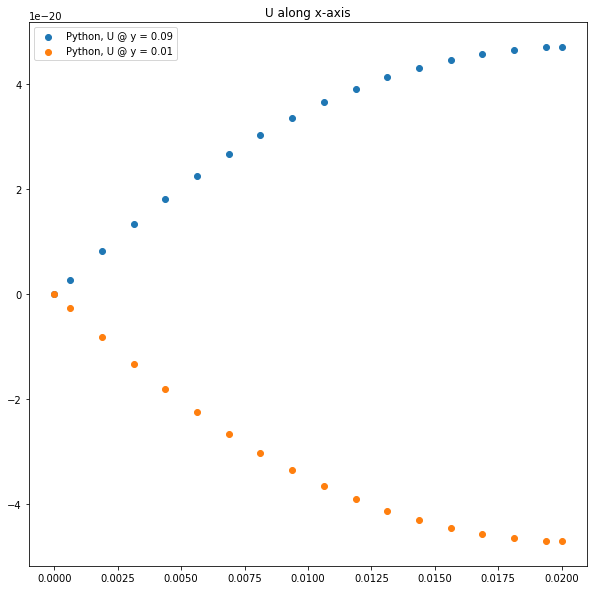

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# plt.plot(df1["arc_length"], df1["D:0"], label = "OF, U @ y = 0.09")

plt.scatter(x, u_reshape_x[ny,:],  label = "Python, U @ y = 0.09")
# plt.plot(df2["arc_length"], df2["D:0"], label = "Fine OF Mesh at 0.098")
plt.scatter(x, u_reshape_x[1,:], label = "Python, U @ y = 0.01")
plt.title("U along x-axis")
plt.legend()

x

Above graph indicates some error in Python model? Further benchmark testing is required
